# Компʼютерний практикум №12
Виконав студент групи ЗК-41мп Гломозда Костянтин

TRANSFER LEARNING (ЧАСТИНА I). АРХІТЕКТУРА RESNET18, RESNET20, CIFARNET

Load data

In [26]:
import torch
import torchvision.datasets
import random
import numpy as np
import time
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

CIFAR_train = torchvision.datasets.CIFAR10('./data', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./data', download=True, train=False)
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

X_train /= 255.
X_test /= 255.

Files already downloaded and verified
Files already downloaded and verified


Visualize

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

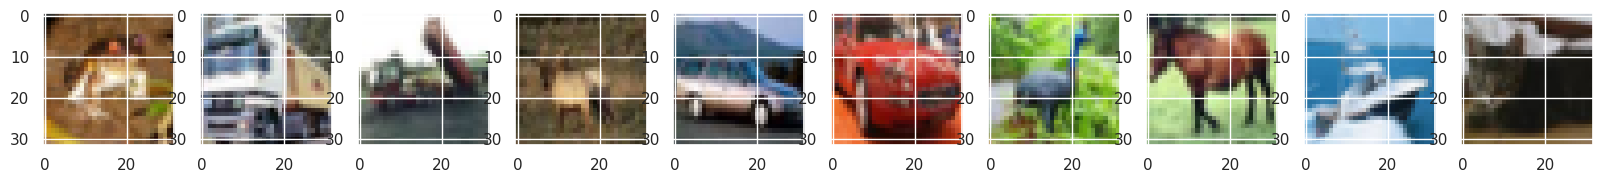

In [27]:
plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')
plt.show()

Prepare data

In [28]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

Train func

In [29]:
def train(net, X_train, y_train, X_test, y_test, batch_size=256,
          epoch_num=50, epoch_info_show=10,
          weight_decay=0, save_net_state=False, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=weight_decay)
    t = time.time()
    test_accuracy_history = []
    test_loss_history = []
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(1, epoch_num+1):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)
            accuracy = (test_preds.argmax(dim=1) ==
            y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            if verbose:
                if epoch % epoch_info_show == 0:
                    if device.type == 'cuda':
                        print('Train Epoch: {} Time: {} Accuracy: {},\
                        GPU_Mem_alloc: {} GPU_Mem_cashed: {}'.format(epoch,
                        time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy,
                        torch.cuda.memory_allocated(), torch.cuda.memory_reserved()))
                    else:
                        print('Train Epoch: {} Time: {} Accuracy:\
                        {}'.format(epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)),
                        accuracy))
    net_state = net.state_dict()
    del net
    if save_net_state:
        return test_accuracy_history, test_loss_history, net_state
    else:
        return test_accuracy_history, test_loss_history
        
accuracies = {}
losses = {}

Visualize

In [30]:
sns.set_style("darkgrid")
sns.set_theme(rc={'figure.figsize':(15, 6)})
def acc_loss_graph(accuracies, losses, net_list,
    save_file_name='plot.png', download=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
        
    ax1.legend()
    ax1.set_title('Validation Accuracy')
    fig.tight_layout()
    for experiment_id in net_list:
        ax2.plot(losses[experiment_id], label=experiment_id)
        
    ax2.legend()
    ax2.set_title('Validation Loss')
    fig.tight_layout()
    if download:
        fig.savefig(save_file_name)

CIFARNet network

In [31]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3 = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.fc1 = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4 = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.act5 = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64, 10)
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        return x

Train CIFAR10

Train Epoch: 10 Time: 00:00:03 Accuracy: 0.7001000046730042,                        GPU_Mem_alloc: 160636928 GPU_Mem_cashed: 1719664640
Train Epoch: 20 Time: 00:00:07 Accuracy: 0.7028999924659729,                        GPU_Mem_alloc: 160636928 GPU_Mem_cashed: 1719664640
Train Epoch: 30 Time: 00:00:10 Accuracy: 0.6943999528884888,                        GPU_Mem_alloc: 160636928 GPU_Mem_cashed: 1719664640
Train Epoch: 40 Time: 00:00:14 Accuracy: 0.7080000042915344,                        GPU_Mem_alloc: 160636928 GPU_Mem_cashed: 1719664640
Train Epoch: 50 Time: 00:00:18 Accuracy: 0.6991999745368958,                        GPU_Mem_alloc: 160636928 GPU_Mem_cashed: 1719664640


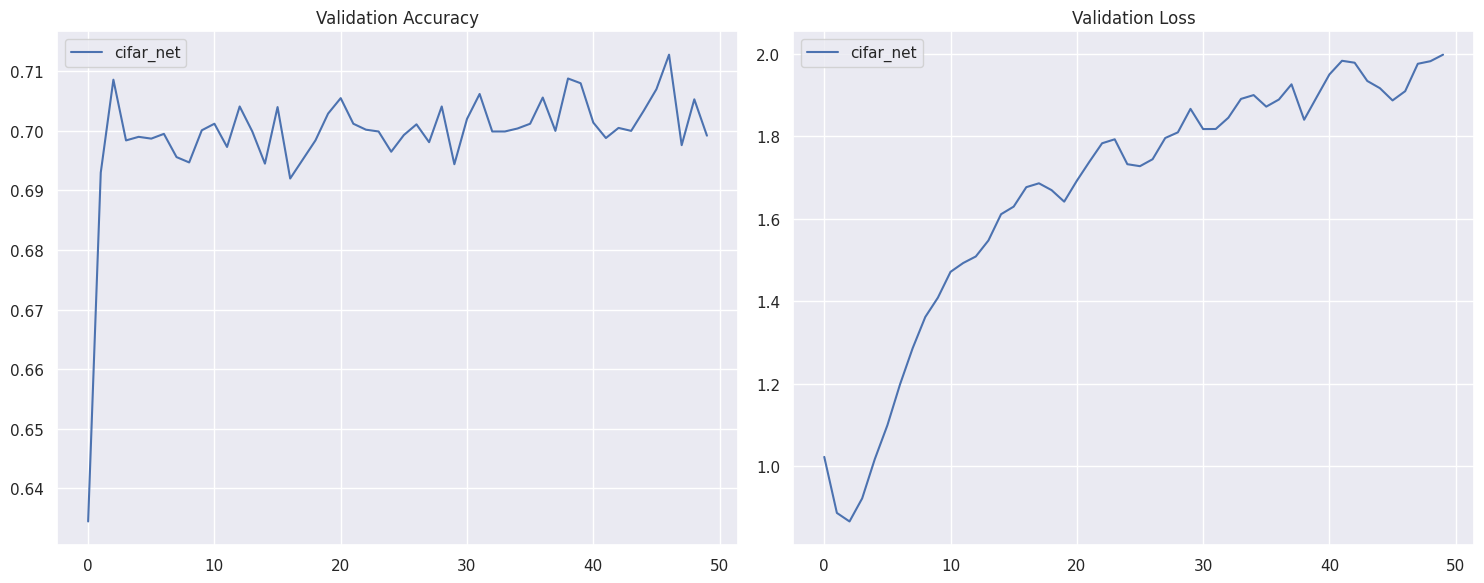

In [32]:
accuracies['cifar_net'], losses['cifar_net'] = train(CIFARNet(), X_train, y_train, X_test, y_test)
acc_loss_graph(accuracies, losses, ['cifar_net'])

ResNet18

Train Epoch: 10 Time: 00:00:10 Accuracy: 0.7148999571800232,                        GPU_Mem_alloc: 373061632 GPU_Mem_cashed: 2403336192
Train Epoch: 20 Time: 00:00:20 Accuracy: 0.7342999577522278,                        GPU_Mem_alloc: 373061632 GPU_Mem_cashed: 2403336192
Train Epoch: 30 Time: 00:00:30 Accuracy: 0.7106999754905701,                        GPU_Mem_alloc: 373061632 GPU_Mem_cashed: 2403336192
Train Epoch: 40 Time: 00:00:40 Accuracy: 0.7531999945640564,                        GPU_Mem_alloc: 373061632 GPU_Mem_cashed: 2403336192
Train Epoch: 50 Time: 00:00:50 Accuracy: 0.7351999878883362,                        GPU_Mem_alloc: 373061632 GPU_Mem_cashed: 2403336192


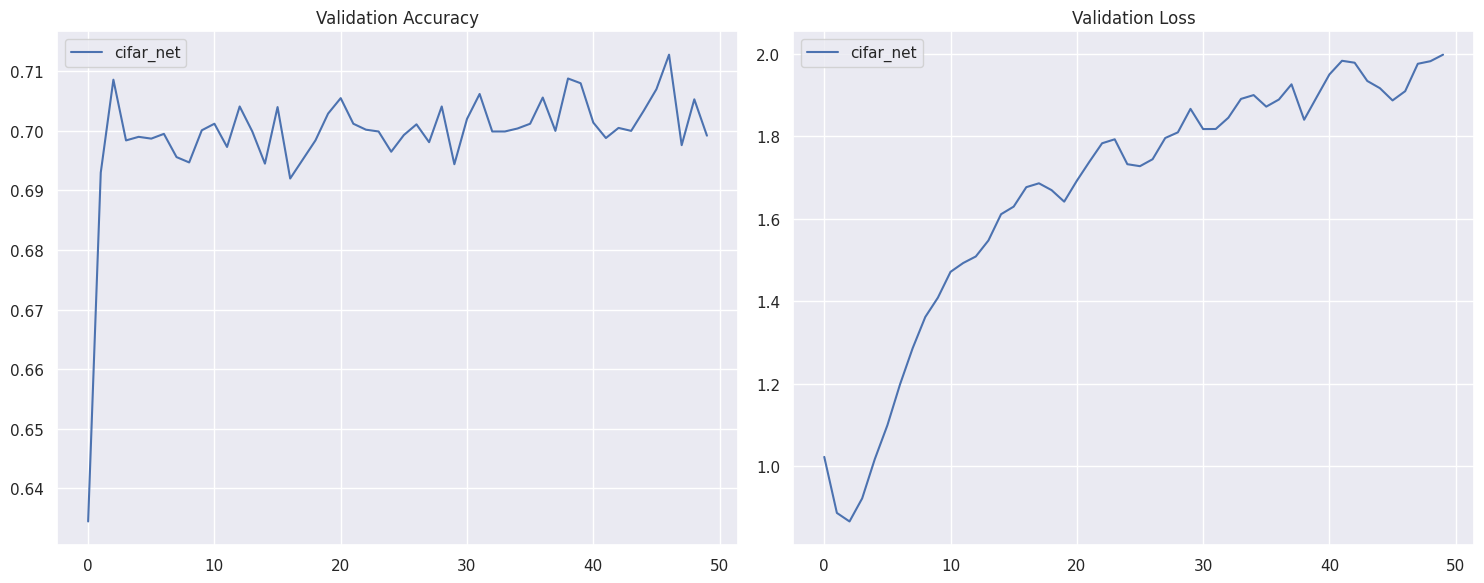

In [34]:
from torchvision.models import resnet18


accuracies['resnet18'], losses['resnet18'] = train(resnet18(), X_train, y_train, X_test, y_test)
acc_loss_graph(accuracies, losses, ['cifar_net'])

ResNet з нуля

In [35]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
    
    
class BasicBlock(torch.nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, option='A',
        use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3,
        stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3,
        stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = torch.nn.Sequential(
                    torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    torch.nn.BatchNorm2d(self.expansion * planes)
                )
    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_drop_out:
            out = self.d_out1(out)
        out = self.act(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
            out = self.bn2(out)
        if self.use_drop_out:
            out = self.d_out2(out)
            
        out += self.shortcut(x)
        out = self.act(out)
        return out
    
class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                          use_batch_norm=self.use_batch_norm,
                          use_drop_out=self.use_drop_out,
                          d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_drop_out:
            out = self.d_out1(out)
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Modification

In [36]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])
def resnet110_no_bn():
    return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False)
def resnet110_d_out15():
    return ResNet(BasicBlock, [18, 18, 18], use_drop_out=True, d_out_p=0.15)
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])
def resnet20_d_out5():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)
def resnet20_d_out3(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.3)
def resnet20_d_out8():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.8)
def resnet20_d_out15():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.15)

In [38]:
print(*[key for key, value in accuracies.items()])

cifar_net resnet18


Train Epoch: 10 Time: 00:00:13 Accuracy: 0.7439999580383301,                        GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 3059744768
Train Epoch: 20 Time: 00:00:27 Accuracy: 0.736299991607666,                        GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 3059744768
Train Epoch: 30 Time: 00:00:41 Accuracy: 0.755299985408783,                        GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 3059744768
Train Epoch: 40 Time: 00:00:55 Accuracy: 0.7479999661445618,                        GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 3059744768
Train Epoch: 50 Time: 00:01:09 Accuracy: 0.7702999711036682,                        GPU_Mem_alloc: 146643456 GPU_Mem_cashed: 3059744768


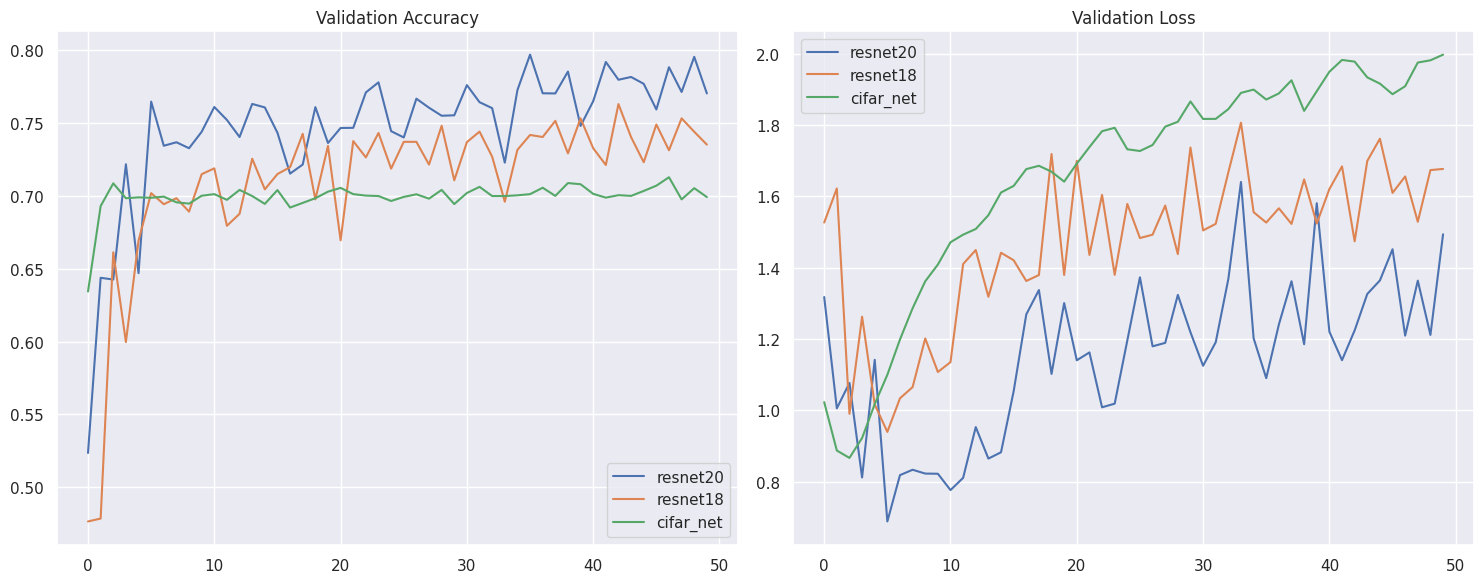

In [39]:
accuracies['resnet20'], losses['resnet20'] = train(resnet20(), X_train, y_train, X_test, y_test)
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet18', 'cifar_net'])

accuracies['resnet110'], losses['resnet110'] = \
train(resnet110(), X_train, y_train, X_test, y_test, batch_size=64)
accuracies['resnet110_no_bn'], losses['resnet110_no_bn'] = \
train(resnet110_no_bn(), X_train, y_train, X_test, y_test,
batch_size=64)